In [1]:
from pylmnn.lmnn import LargeMarginNearestNeighbor as LMNN


from __future__ import print_function, division
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import os
import numpy as np
import time
import torch.cuda as cuda
import pickle

from data_processing import Dataset
import random
import matplotlib
from matplotlib import cm, pyplot as plt
import matplotlib.font_manager as font_manager

/home/drone/newanaconda2/envs/dronev3/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/drone/newanaconda2/envs/dronev3/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/drone/newanaconda2/envs/dronev3/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/drone/newanaconda2/envs/dronev3/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_firs

In [2]:
'''
pickle file is organized as
1. train --> class --> objs (each obj has 12 views)
                   --> labels (the class label for the object)
                   
2. test --> class --> objs (each obj has 12 views)
                  --> labels (the class label for the object)
'''
pickle_filename = 'oowl_sorted_single_copy.pickle'

In [3]:
# load dataset
def load_data(pickle_filename):

    train = {}
    train['objs'] = []
    train['labels'] = []
    test = {}
    test['objs'] = []
    test['labels'] = []
    with open(pickle_filename, "rb") as input_file:
        data = pickle.load(input_file)    
    
    for c in data['train']:
        for obj in data['train'][c]:
            train['objs'].append(data['train'][c][obj]['objs'])
            train['labels'].append(data['train'][c][obj]['labels'])
            
    for c in data['test']:
        for obj in data['test'][c]:
            test['objs'].append(data['test'][c][obj]['objs'])
            test['labels'].append(data['test'][c][obj]['labels'])
            
    return train, test

In [4]:
# Read list of training and validation data
train, test = load_data(pickle_filename)

In [5]:
dataset_train = Dataset(train, shuffle_f=False, V=8)
dataset_test = Dataset(test, shuffle_f=False, V=8)

In [6]:
train_npy = np.load('train_feature_npy/VGG_pool_OOWL_single_cpy.npy')
test_npy = np.load('test_feature_npy/VGG_pool_OOWL_single_cpy.npy')

In [7]:
# Set up the hyperparameters
k_tr, dim_out, max_iter = 3, 128, 1
# Instantiate the classifier
clf = LMNN(n_neighbors=k_tr, max_iter=max_iter, n_features_out=dim_out)
clf.L_ = np.load('mahalanobis_dist/VGG_pool_OOWL_single_cpy_15nn_20iter_L.npy')

In [8]:
train_npy_trans = clf.transform(train_npy)
test_npy_trans = clf.transform(test_npy)

In [9]:
dst = np.zeros((test_npy_trans.shape[0],train_npy_trans.shape[0]))
for i in range(test_npy_trans.shape[0]):
    for j in range(train_npy_trans.shape[0]):
        dst[i,j] = np.sum(np.square(test_npy_trans[i,:] - train_npy_trans[j,:]))          

In [10]:
sorted_index = np.argsort(dst,1)

In [11]:
precision = []
rank_size = 0
for i in range(test_npy_trans.shape[0]):
    count = 0
    p=[]
    for Rank in range(train_npy_trans.shape[0]):
        if dataset_test.data['labels'][i]==dataset_train.data['labels'][sorted_index[i,Rank]]:
            count+=1
            p=np.append(p,count/(Rank+1))

            
    p = np.expand_dims(p, axis=0)        
    if len(precision)==0:
        precision = p
        rank_size = precision.shape[1]
    else:        
        precision = np.concatenate((precision,p))
         

In [12]:
average_precision = np.mean(precision, axis=0)
mAP = np.mean(average_precision)

In [13]:
print(mAP)

0.7335879895188573


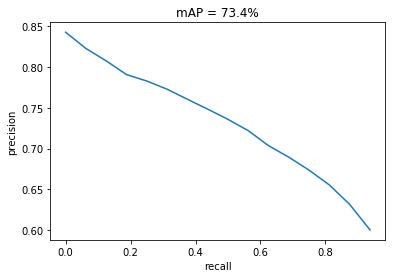

In [14]:
xAxis = np.divide(range(0,rank_size),1.0*rank_size)
plt.figure()
plt.plot(xAxis,average_precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('mAP = ' + str(round(mAP,3)*100) + '%')
plt.show()

plt.savefig('OOWL_mAP_plot_with_metric.png')

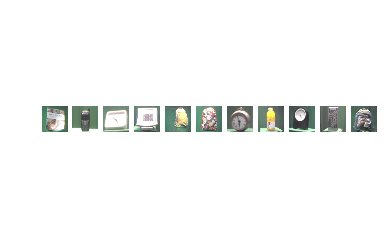

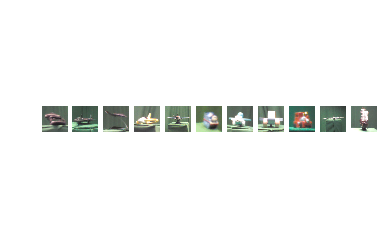

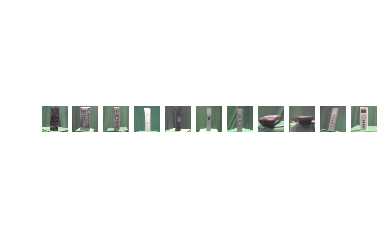

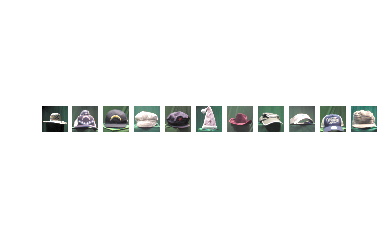

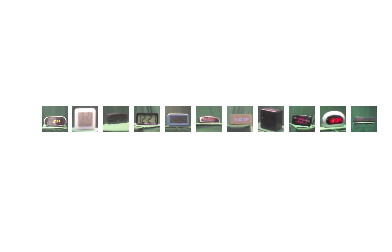

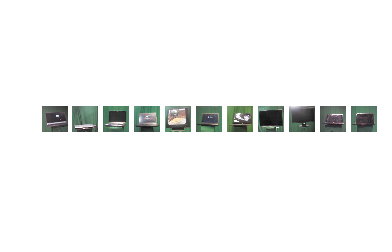

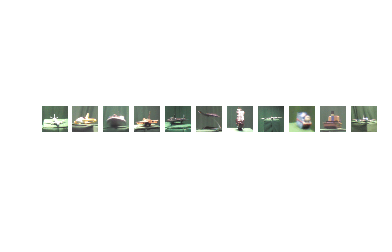

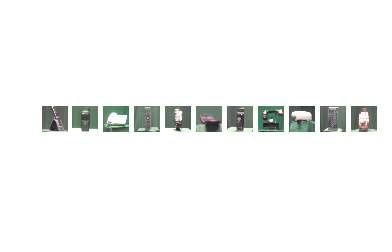

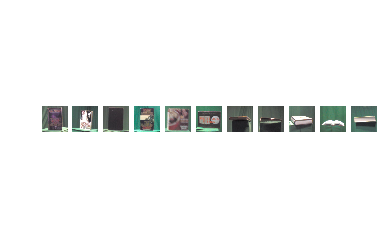

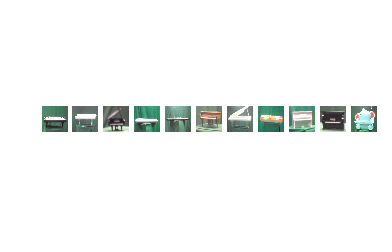

In [15]:
sample_test = random.sample(range(sorted_index.shape[0]), 10)

for s in sample_test:
    fig, axes = plt.subplots(nrows=1, ncols=11, sharex=True)
    im = plt.imread(test['objs'][s][0])
    axes[0].axis('off')
    axes[0].imshow(im)
    for top in range(10):
        plt.axis('off')
        rtr_obj = sorted_index[s][top]
        im_rtr = plt.imread(train['objs'][rtr_obj][0])
        axes[top+1].axis('off')
        axes[top+1].imshow(im_rtr)

plt.show()